# 5. ML Modelling

* We'll build various models on the 561 Enginnered Features data and compare each of them.

In [317]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import confusion_matrix, accuracy_score, log_loss

from IPython.display import display

%matplotlib inline


plt.rcParams["font.family"] = 'DejaVu Sans'
plt.rcParams['figure.dpi'] = 100

__LOADING THE DATA__

In [2]:
TRAIN = pd.read_csv('UCI_HAR_Dataset/csv_files/TRAIN.csv')
TEST = pd.read_csv('UCI_HAR_Dataset/csv_files/TEST.csv')

print(f"Shape of TRAIN : {TRAIN.shape}")
print(f"Shape of TEST  : {TEST.shape}")

Shape of TRAIN : (7352, 564)
Shape of TEST  : (2947, 564)


In [183]:
ACTIVITY_NAMES = list(TRAIN[['ActivityName', 'Activity']].groupby(['ActivityName', 'Activity']).count().index)
ACTIVITY_NAMES.sort(key=lambda x : x[1])
print(ACTIVITY_NAMES)
ACTIVITY_NAMES = [x[0] for x in ACTIVITY_NAMES]

[('WALKING', 1), ('WALKING_UPSTAIRS', 2), ('WALKING_DOWNSTAIRS', 3), ('SITTING', 4), ('STANDING', 5), ('LAYING', 6)]


In [4]:
Ytrain = TRAIN.Activity.values
Xtrain = TRAIN.drop(['subject', 'Activity', 'ActivityName'], axis=1)

Ytest = TEST.Activity.values
Xtest = TEST.drop(['subject', 'Activity', 'ActivityName'], axis=1)

__FUNCTION TO PRINT THE PERFORMANCE__

In [315]:
def metrics_report(Xtrain, Ytrain, Xtest, Ytest, estimator, label_names=ACTIVITY_NAMES):
    
    sig_clf = CalibratedClassifierCV(estimator, method="sigmoid")
    sig_clf.fit(Xtrain, Ytrain)
    test_sig_probs = sig_clf.predict_proba(Xtest)
    train_sig_probs = sig_clf.predict_proba(Xtrain)
    
    train_lgl = np.round(log_loss(Ytrain, train_sig_probs), 3)
    train_acc = np.round(accuracy_score(Ytrain, train_sig_probs.argmax(1)+1), 3)
    
    test_lgl = np.round(log_loss(Ytest, test_sig_probs), 3)
    test_acc = np.round(accuracy_score(Ytest, test_sig_probs.argmax(1)+1), 3)
    
    display(pd.DataFrame([[train_acc, train_lgl], [test_acc, test_lgl]], columns=['ACCURACY', 'LOG_LOSS'], index=['TRAIN', 'TEST']))
    display(pd.DataFrame.from_dict(classification_report(Ytest, estimator.predict(Xtest), target_names=label_names, output_dict=True),
                                   orient='index'))
    
    return [train_acc, train_lgl, test_acc, test_lgl]

__FUNCTION TO PLOT THE CONFUSION MATRIX__

In [323]:
def plot_confusion_matrix(Ytrue, Ypred, labels=ACTIVITY_NAMES):
    
    C = confusion_matrix(Ytrue, Ypred)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
    
    sns.heatmap(C, annot=True, cmap='Spectral_r', fmt='d',
                xticklabels=labels, yticklabels=labels, linewidths=0.5, ax=ax1)
    ax1.set_title('Confusion Matrix', fontsize=15)
    ax1.set_xlabel('PREDICTED_LABEL', fontsize=12)
    ax1.set_ylabel('TRUE_LABEL', fontsize=12)
    
    
    sns.heatmap(C/C.sum(1), annot=True, cmap='Spectral_r', fmt='.3f',
                xticklabels=labels, yticklabels=labels, linewidths=0.5, ax=ax2)
    ax2.set_title('Normalized Confusion Matrix', fontsize=15)
    ax2.set_xlabel('PREDICTED_LABEL', fontsize=12)
    ax2.set_ylabel('TRUE_LABEL',fontsize=12)

    fig.tight_layout()

In [172]:
models_eval_dict = {}
models_eval_dict['columns'] = ['TRAIN_ACC', 'TRAIN_LOG_LOSS', 'TEST_ACC', 'TEST_LOG_LOSS']

## 5.1 Logistic Regression

In [188]:
from sklearn.linear_model import LogisticRegression

In [205]:
parameters = {'C' : np.logspace(-4, 2, 9), 'penalty' : ['l2']}
log_regr_grid_cv = GridSearchCV(LogisticRegression(max_iter=500), param_grid=parameters, cv=3, n_jobs=-1)
log_regr_grid_cv.fit(Xtrain, Ytrain)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=500, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': array([1.00000e-04, 5.62341e-04, 3.16228e-03, 1.77828e-02, 1.00000e-01,
       5.62341e-01, 3.16228e+00, 1.77828e+01, 1.00000e+02]), 'penalty': ['l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [242]:
log_regr_grid_cv.best_params_

{'C': 17.78279410038923, 'penalty': 'l2'}

In [316]:
models_eval_dict['LOG_REG'] = metrics_report(Xtrain, Ytrain, Xtest, Ytest, log_regr_grid_cv.best_estimator_)

,ACCURACY,LOG_LOSS
TRAIN,0.994,0.069
TEST,0.965,0.160


,precision,recall,f1-score,support
LAYING,0.998141,1.000000,0.999070,537
SITTING,0.972603,0.867617,0.917115,491
STANDING,0.896373,0.975564,0.934293,532
WALKING,0.948276,0.997984,0.972495,496
WALKING_DOWNSTAIRS,0.997555,0.971429,0.984318,420
WALKING_UPSTAIRS,0.973970,0.953291,0.963519,471
macro avg,0.964486,0.960981,0.961802,2947
micro avg,0.961656,0.961656,0.961656,2947
weighted avg,0.963175,0.961656,0.961465,2947


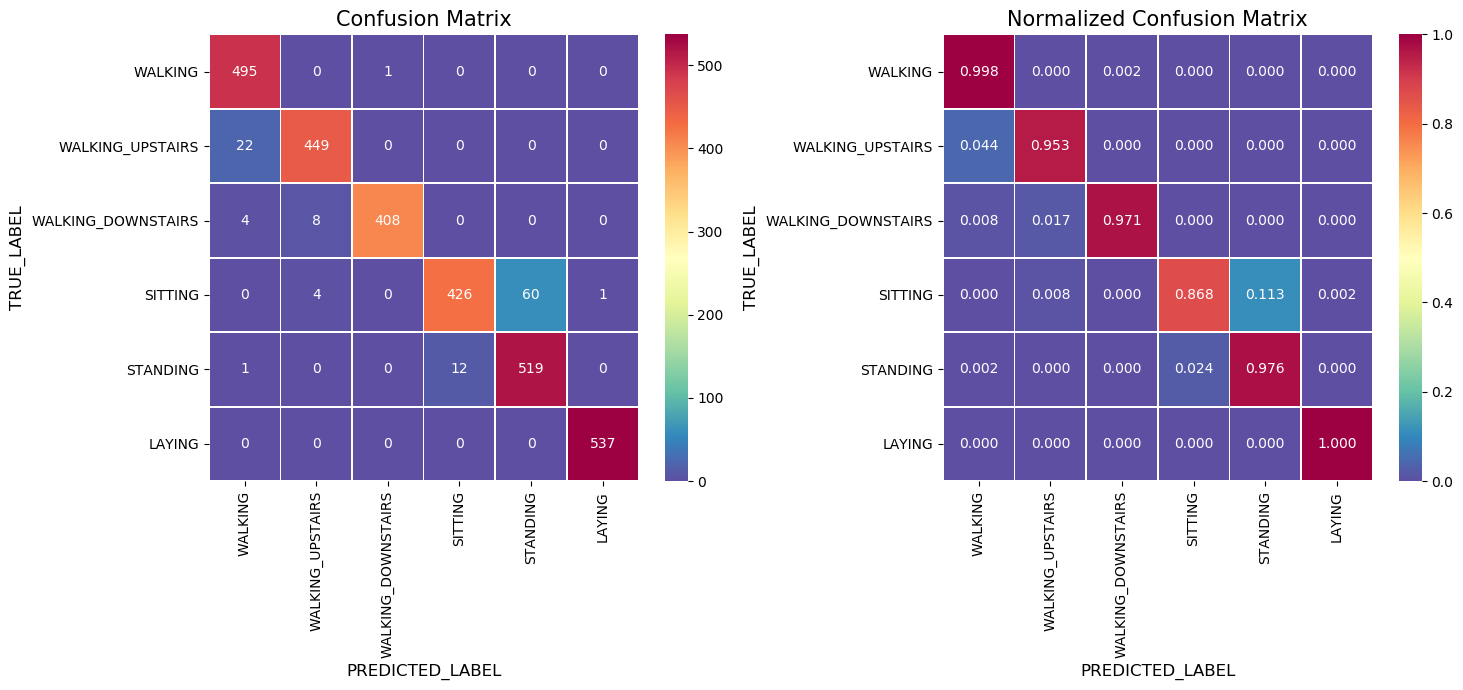

In [324]:
plot_confusion_matrix(Ytest, log_regr_grid_cv.best_estimator_.predict(Xtest))

__<font color='green'>OBSERVATIONS</font>__

* The very first model built has achieved a good accuracy score.
* The precision and recall values of all the classes seem to be good except the classes STANDING, SITTING.
* The precison of STANDING and the recall of SITTING took the hit due the to classes STANDING and SITTING which little to no motion info and seem to be same.

## 5.2 Linear SVM

In [189]:
from sklearn.svm import LinearSVC

In [198]:
parameters = {'C' : np.logspace(-3, 2, 9)}
lin_svm_grid_cv = GridSearchCV(LinearSVC(), param_grid=parameters, cv=3, n_jobs=-1)
lin_svm_grid_cv.fit(Xtrain, Ytrain)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': array([1.00000e-03, 4.21697e-03, 1.77828e-02, 7.49894e-02, 3.16228e-01,
       1.33352e+00, 5.62341e+00, 2.37137e+01, 1.00000e+02])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [243]:
lin_svm_grid_cv.best_params_

{'C': 5.623413251903491}

In [318]:
models_eval_dict['LINEAR_SVM'] = metrics_report(Xtrain, Ytrain, Xtest, Ytest, lin_svm_grid_cv.best_estimator_)

,ACCURACY,LOG_LOSS
TRAIN,0.995,0.071
TEST,0.965,0.166


,precision,recall,f1-score,support
LAYING,0.996289,1.000000,0.998141,537
SITTING,0.966063,0.869654,0.915327,491
STANDING,0.900697,0.971805,0.934901,532
WALKING,0.970588,0.997984,0.984095,496
WALKING_DOWNSTAIRS,0.997585,0.983333,0.990408,420
WALKING_UPSTAIRS,0.976496,0.970276,0.973376,471
macro avg,0.967953,0.965509,0.966041,2947
micro avg,0.965728,0.965728,0.965728,2947
weighted avg,0.966692,0.965728,0.965503,2947


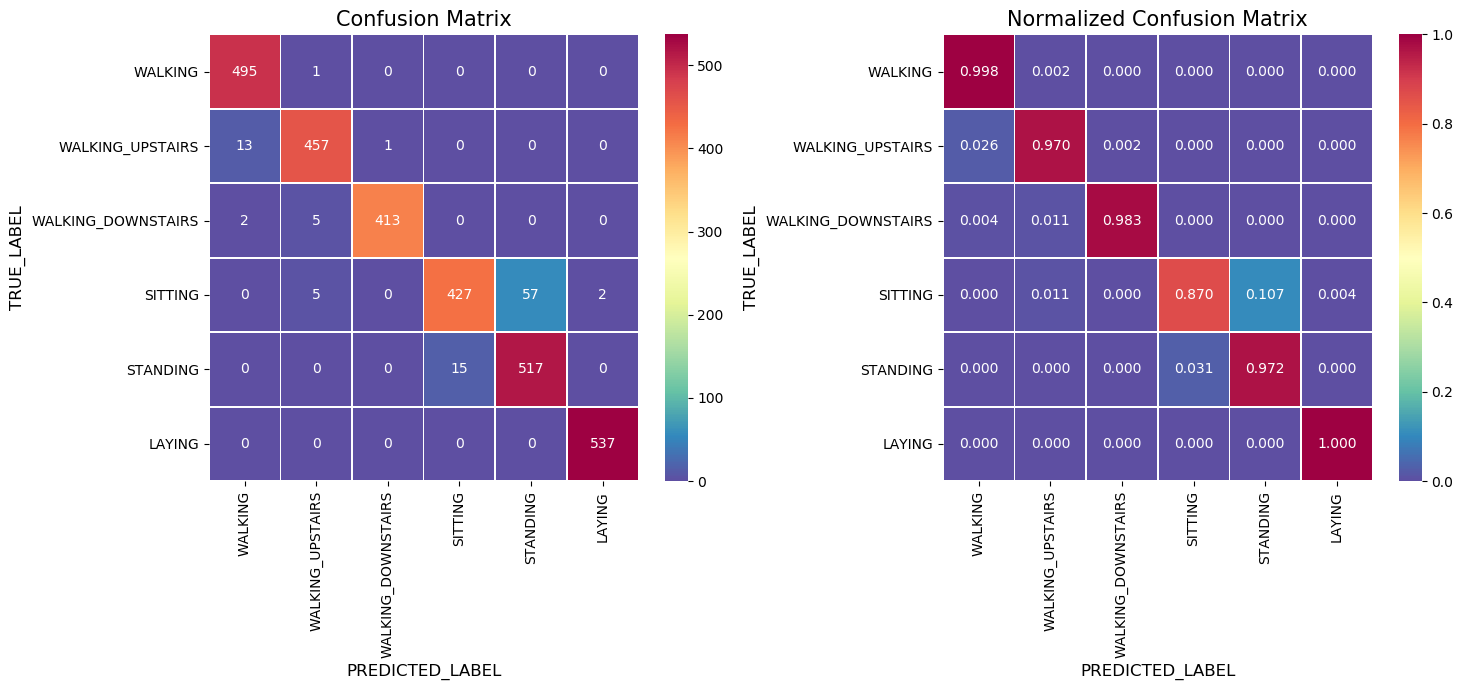

In [325]:
plot_confusion_matrix(Ytest, lin_svm_grid_cv.best_estimator_.predict(Xtest))

__<font color='green'>OBSERVATIONS</font>__

* The Linear SVM performed as similar to Logistic Regression.
* The issue seems to be same as the previous one with other classes having good precision and recall values.

## 5.3 Kernel SVM

In [212]:
from sklearn.svm import SVC

In [213]:
parameters = {'C' : [2, 8, 16], 'gamma': [ 0.0078125, 0.125, 2]}
rbf_svm_grid_cv = GridSearchCV(SVC(kernel='rbf'), param_grid=parameters, n_jobs=-1, cv=3)
rbf_svm_grid_cv.fit(Xtrain, Ytrain)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'C': [2, 8, 16], 'gamma': [0.0078125, 0.125, 2]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [244]:
rbf_svm_grid_cv.best_params_

{'C': 16, 'gamma': 0.0078125}

In [320]:
models_eval_dict['RBF_SVM'] = metrics_report(Xtrain, Ytrain, Xtest, Ytest, rbf_svm_grid_cv.best_estimator_)

,ACCURACY,LOG_LOSS
TRAIN,0.996,0.084
TEST,0.960,0.155


,precision,recall,f1-score,support
LAYING,1.000000,1.000000,1.000000,537
SITTING,0.973510,0.898167,0.934322,491
STANDING,0.915493,0.977444,0.945455,532
WALKING,0.958824,0.985887,0.972167,496
WALKING_DOWNSTAIRS,0.992500,0.945238,0.968293,420
WALKING_UPSTAIRS,0.945720,0.961783,0.953684,471
macro avg,0.964341,0.961420,0.962320,2947
micro avg,0.962674,0.962674,0.962674,2947
weighted avg,0.963657,0.962674,0.962605,2947


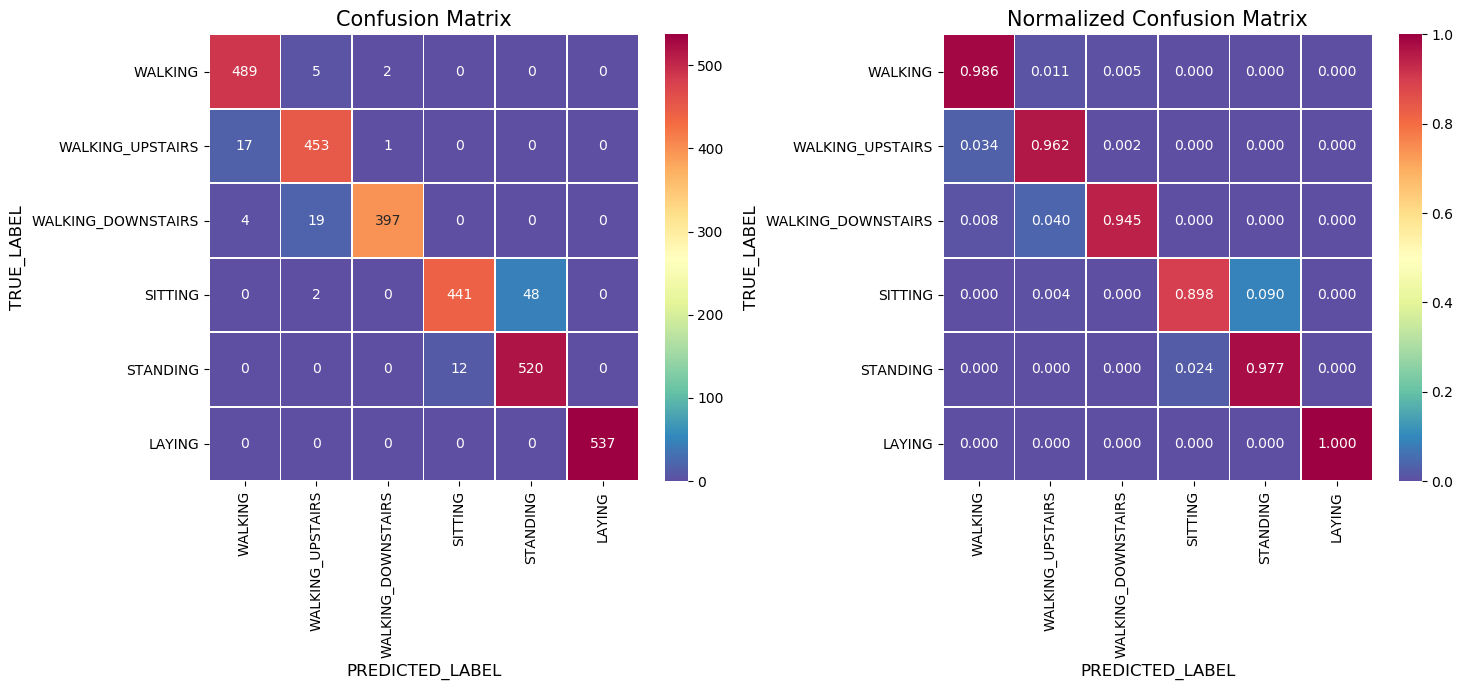

In [328]:
plot_confusion_matrix(Ytest, rbf_svm_grid_cv.best_estimator_.predict(Xtest))

__<font color='green'>OBSERVATIONS</font>__

* The RBF SVM slighlty increases performance on the classes SITTING and STANDING.
* But some of the other classes take a hit.

## 5.4 Decision Trees

In [216]:
from sklearn.tree import DecisionTreeClassifier

In [220]:
parameters = {'max_depth' : np.arange(4, 11)}
dt_grid_cv = GridSearchCV(DecisionTreeClassifier(min_samples_split=5), param_grid=parameters, n_jobs=-1, cv=3)
dt_grid_cv.fit(Xtrain, Ytrain)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=5,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': array([ 4,  5,  6,  7,  8,  9, 10])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [326]:
models_eval_dict['DECISION_TREE'] = metrics_report(Xtrain, Ytrain, Xtest, Ytest, dt_grid_cv.best_estimator_)

,ACCURACY,LOG_LOSS
TRAIN,0.953,0.269
TEST,0.874,0.440


,precision,recall,f1-score,support
LAYING,1.000000,1.000000,1.000000,537
SITTING,0.888889,0.700611,0.783599,491
STANDING,0.768868,0.919173,0.837329,532
WALKING,0.864916,0.929435,0.896016,496
WALKING_DOWNSTAIRS,0.750542,0.823810,0.785471,420
WALKING_UPSTAIRS,0.872774,0.728238,0.793981,471
macro avg,0.857665,0.850211,0.849399,2947
micro avg,0.855107,0.855107,0.855107,2947
weighted avg,0.861142,0.855107,0.853577,2947


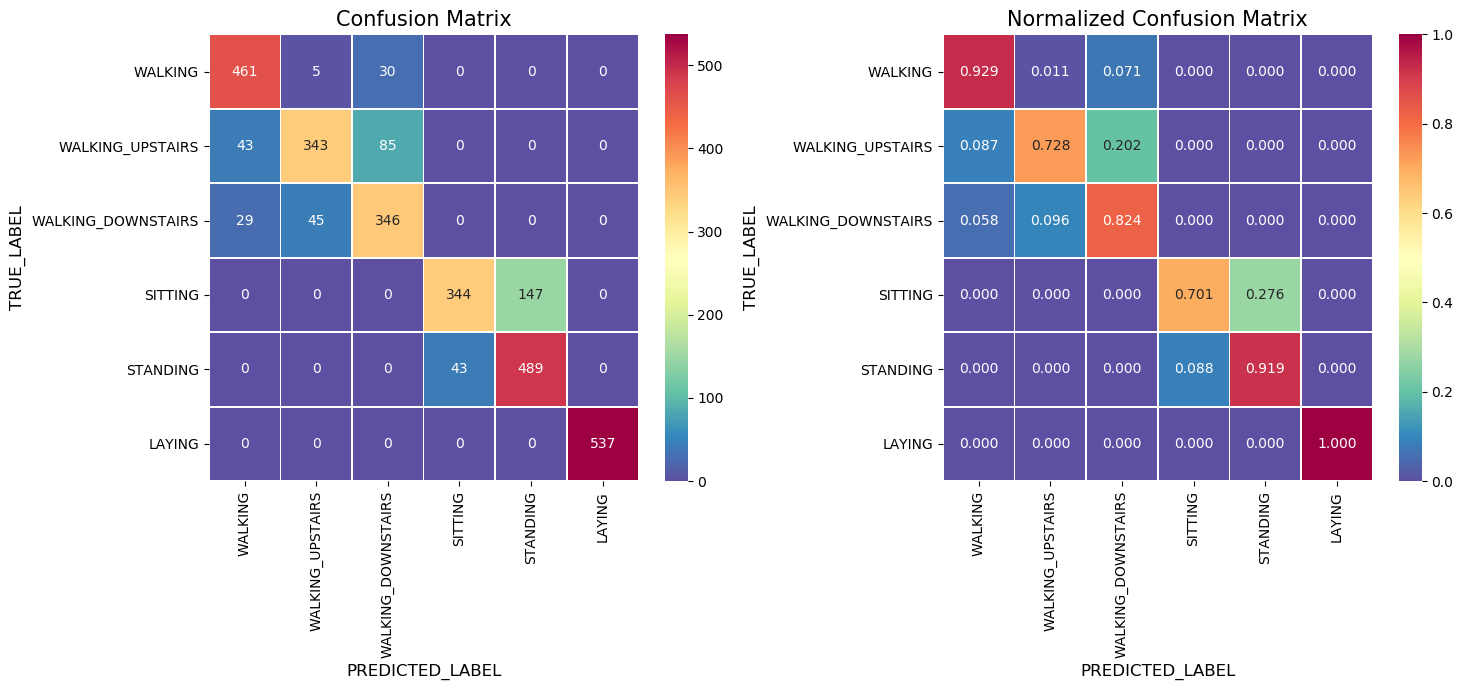

In [327]:
plot_confusion_matrix(Ytest, dt_grid_cv.best_estimator_.predict(Xtest))

__<font color='green'>OBSERVATIONS</font>__

* The Tree based Decision Tree peformed worse than the linear models.
* The performance of the moving activities is messed up.

## 5.5 Random Forests

In [227]:
from sklearn.ensemble import RandomForestClassifier

In [232]:
params = {'n_estimators' : np.arange(10,201,20), 'max_depth' : np.arange(3, 11, 2)}
rf_grid_cv = GridSearchCV(RandomForestClassifier(), param_grid=params, cv=3, n_jobs=-1)
rf_grid_cv.fit(Xtrain, Ytrain)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': array([ 10,  30,  50,  70,  90, 110, 130, 150, 170, 190]), 'max_depth': array([3, 5, 7, 9])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [233]:
rf_grid_cv.best_params_

{'max_depth': 7, 'n_estimators': 70}

In [329]:
models_eval_dict['RANDOM_FORESTS'] = metrics_report(Xtrain, Ytrain, Xtest, Ytest, rf_grid_cv.best_estimator_)

,ACCURACY,LOG_LOSS
TRAIN,0.978,0.099
TEST,0.916,0.238


,precision,recall,f1-score,support
LAYING,1.000000,1.000000,1.000000,537
SITTING,0.932127,0.839104,0.883173,491
STANDING,0.864028,0.943609,0.902066,532
WALKING,0.863063,0.965726,0.911513,496
WALKING_DOWNSTAIRS,0.951977,0.802381,0.870801,420
WALKING_UPSTAIRS,0.887029,0.900212,0.893572,471
macro avg,0.916371,0.908505,0.910188,2947
micro avg,0.913132,0.913132,0.913132,2947
weighted avg,0.916199,0.913132,0.912540,2947


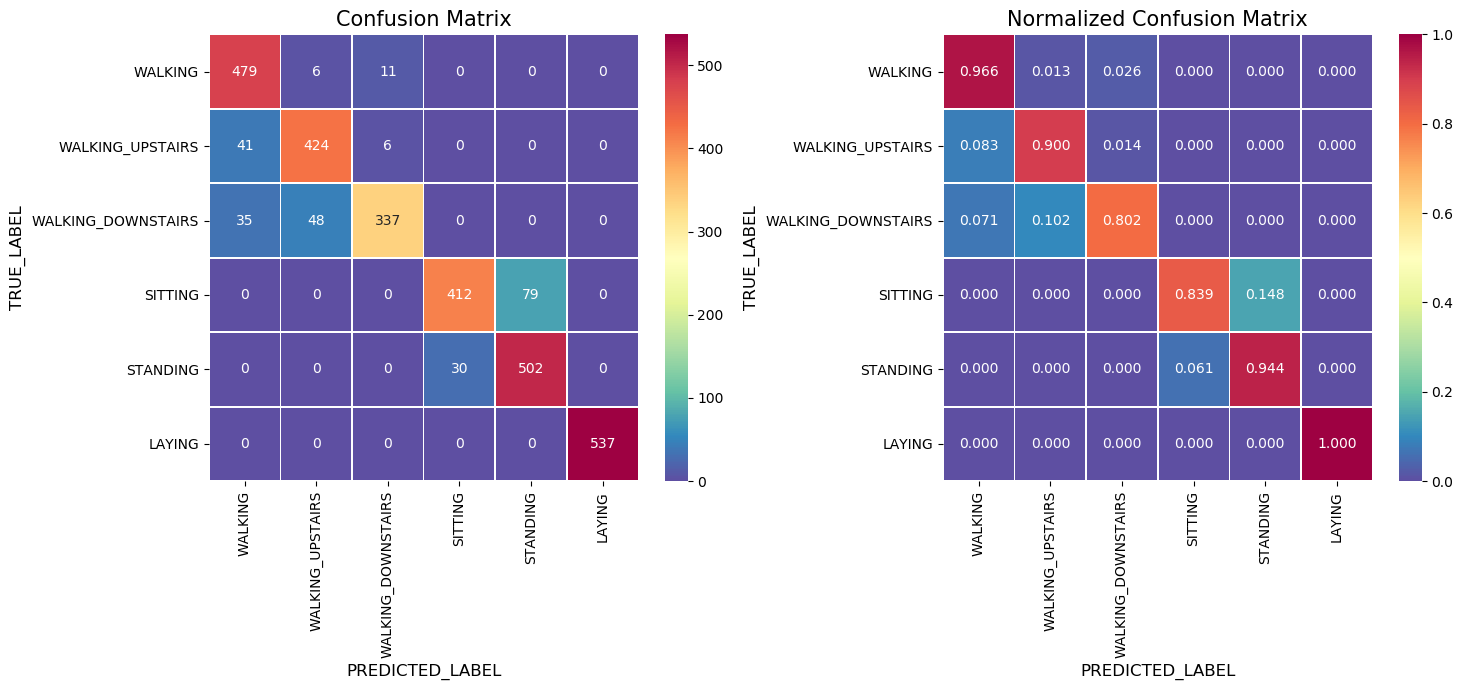

In [330]:
plot_confusion_matrix(Ytest, rf_grid_cv.best_estimator_.predict(Xtest))

__<font color='green'>OBSERVATIONS</font>__

* The performance slighlty increases over the simple decision tree but is still worse.

## 5.6 XGBoost

In [236]:
from xgboost import XGBClassifier

In [238]:
parameters = {'n_estimators' : [10, 20, 40, 80, 150],
              'max_depth' : np.arange(3, 10, 2),
              'min_child_weight' : [2, 3, 4, 5, 6],
              'learning_rate' : [0.1, 0.3,  0.5, 0.7,  0.9],
              'colsample_bytree' : [0.5, 0.75, 1]}

xgb_grid_cv = RandomizedSearchCV(XGBClassifier(), param_distributions=parameters, cv=3, n_jobs=-1)
xgb_grid_cv.fit(Xtrain, Ytrain)

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
          fit_params=None, iid='warn', n_iter=10, n_jobs=-1,
          param_distributions={'n_estimators': [10, 20, 40, 80, 150], 'max_depth': array([3, 5, 7, 9]), 'min_child_weight': [2, 3, 4, 5, 6], 'learning_rate': [0.1, 0.3, 0.5, 0.7, 0.9], 'colsample_bytree': [0.5, 0.75, 1]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [239]:
xgb_grid_cv.best_params_

{'n_estimators': 80,
 'min_child_weight': 6,
 'max_depth': 3,
 'learning_rate': 0.3,
 'colsample_bytree': 0.5}

In [331]:
models_eval_dict['XGBOOST'] = metrics_report(Xtrain, Ytrain, Xtest, Ytest, xgb_grid_cv.best_estimator_)

,ACCURACY,LOG_LOSS
TRAIN,1.000,0.085
TEST,0.932,0.201


,precision,recall,f1-score,support
LAYING,1.000000,1.000000,1.000000,537
SITTING,0.942982,0.875764,0.908131,491
STANDING,0.898757,0.951128,0.924201,532
WALKING,0.926692,0.993952,0.959144,496
WALKING_DOWNSTAIRS,0.982368,0.928571,0.954712,420
WALKING_UPSTAIRS,0.937229,0.919321,0.928189,471
macro avg,0.948005,0.944789,0.945729,2947
micro avg,0.946386,0.946386,0.946386,2947
weighted avg,0.947340,0.946386,0.946202,2947


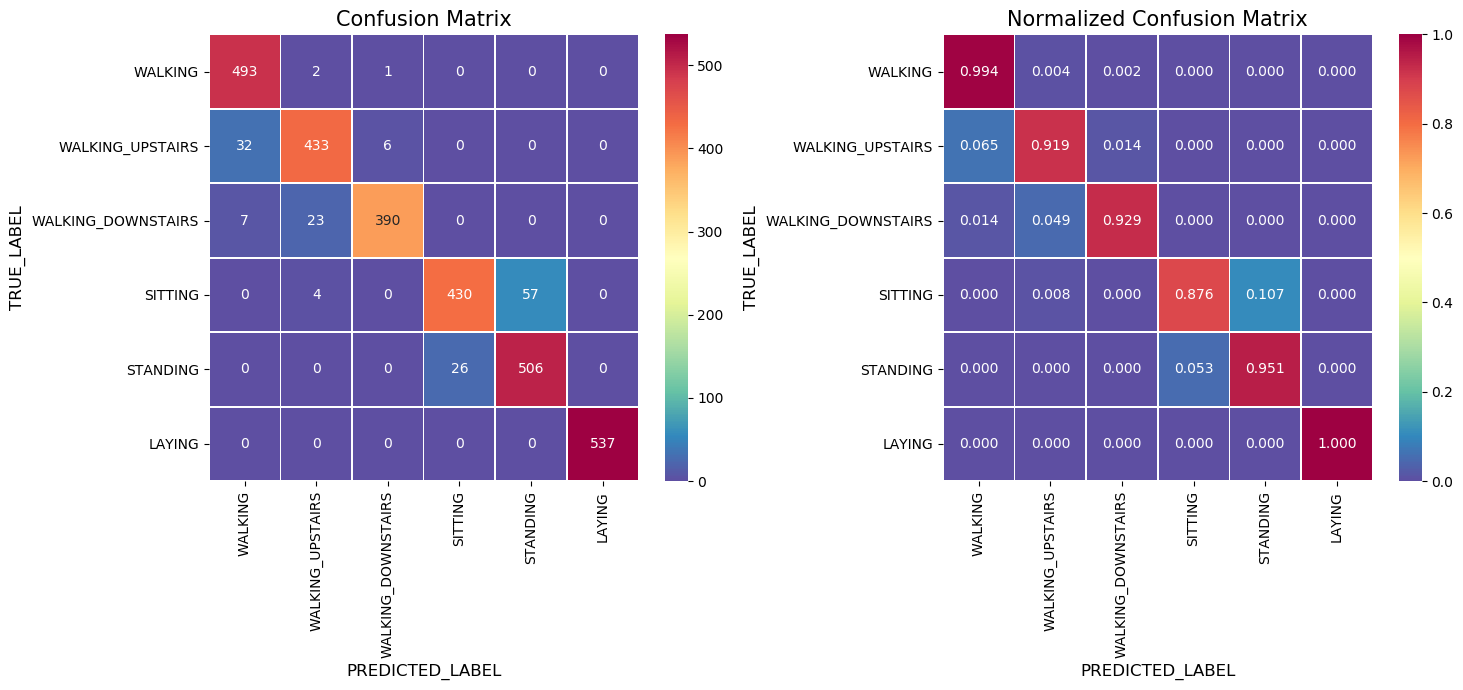

In [332]:
plot_confusion_matrix(Ytest, xgb_grid_cv.best_estimator_.predict(Xtest))

__<font color='green'>OBSERVATIONS</font>__

* The GBDT model slighlty improved over the Random Forests model.
* This model is likely overfit as the gap between train and test is large.

## 5.7 Models summary

In [341]:
if 'columns' in models_eval_dict:
    columns = models_eval_dict.pop('columns')
pd.DataFrame.from_dict(models_eval_dict, orient='index', columns=columns).sort_values('TEST_ACC', ascending=False)

,TRAIN_ACC,TRAIN_LOG_LOSS,TEST_ACC,TEST_LOG_LOSS
LOG_REG,0.994,0.069,0.965,0.160
LINEAR_SVM,0.995,0.071,0.965,0.166
RBF_SVM,0.996,0.084,0.960,0.155
XGBOOST,1.000,0.085,0.932,0.201
RANDOM_FORESTS,0.978,0.099,0.916,0.238
DECISION_TREE,0.953,0.269,0.874,0.440


## 5.8 Conclusion

* We've built a total of 6 models over the 561 engineered features data.
* The Linear Classifiers came out on top with similar performances.
* The Tree based models which are Non-Linear Classifiers were bad at performance.
* As we've seen from EDA, the class __LAYING__ had terrific performance.
* The classes whose performances have taken a blow are __STANDING and SITTING__, this is due to thier similarities.

__Please Open the Next Notebook where We use Deep Learning in building Models.__